In [58]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import subprocess
import sys
sys.path.append('../..')

import pickle
import numpy as np
import matplotlib.pyplot as plt

from IRSMicroLensing import IRSCaustics as IRSC
from IRSMicroLensing import IRSFunctions as IRSF

import VBMicrolensing
from skimage.draw import line

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Initializing VBMicrolensing

In [59]:
VBM = VBMicrolensing.VBMicrolensing()

# Set relative accuracy
VBM.RelTol = 1e-03

# Set accuracy
VBM.Tol=1e-03

#### Defining reader function to read in IRSCaustic objects from file

In [60]:
def caustic_reader(file_path: str) -> IRSC.IRSCaustics:
    with open(file_path, 'rb') as f:
        return pickle.load(f)

#### Reading in single lens and triple lens objects

In [ ]:
single_lens = caustic_reader('../Simulations/single_lens_1e11.pkl')
triple_lens = caustic_reader('../Simulations/triple_lens_1e11.pkl')

ang_width = single_lens.ang_width
pixels = single_lens.pixels
ang_res = single_lens.ang_res

print(f'Number of rays: {single_lens.num_rays:.4e}')
print(f'Number of rays: {triple_lens.num_rays:.4e}')

Number of rays: 1.5192e+11
Number of rays: 1.5192e+11


#### Viewing magnification maps

Plotting magnification map: 0.024 seconds
Saving magnification map: 1.879 seconds
Plotting magnification map: 0.017 seconds
Saving magnification map: 1.856 seconds


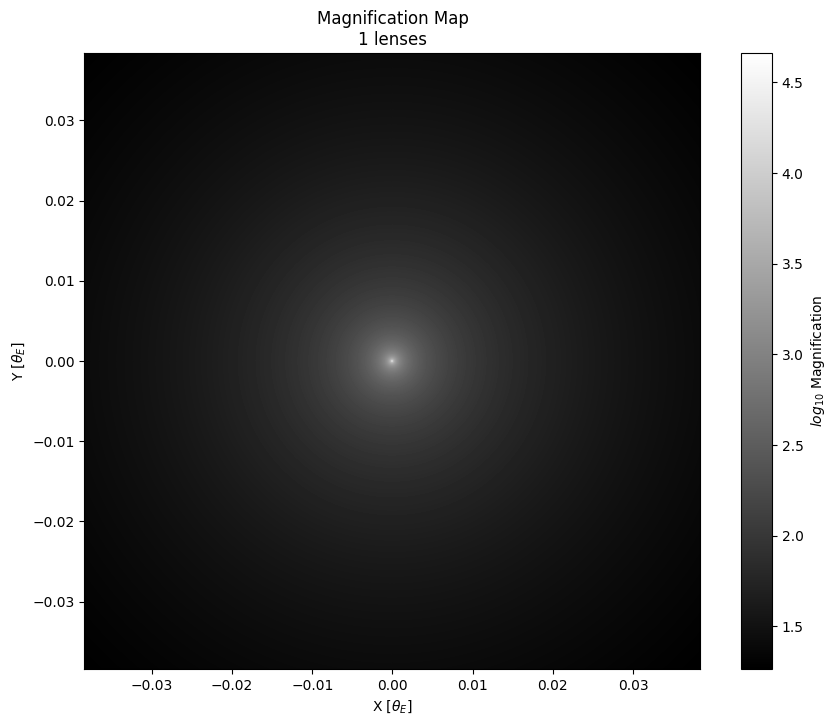

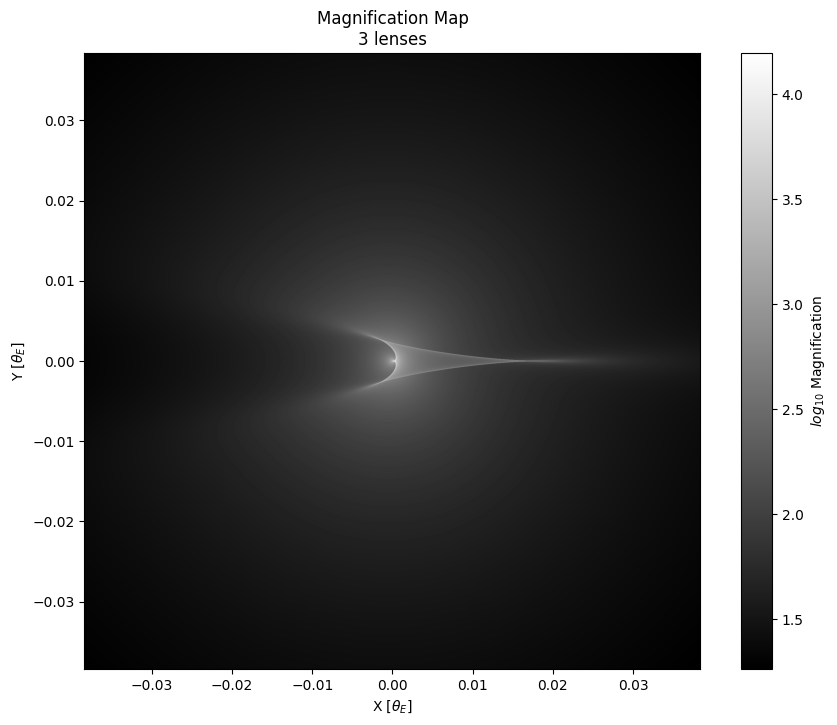

In [ ]:
single_lens.plot(save_plot='Single Lens Accurate')
triple_lens.plot(save_plot='Triple Lens Accurate')

plt.show()

#### Defining source profile

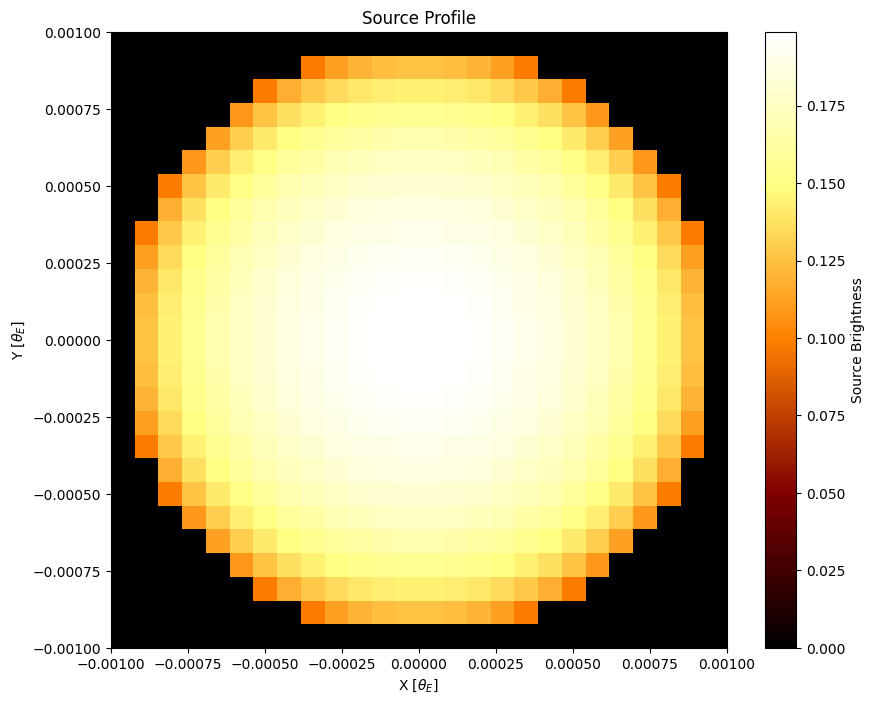

In [50]:
radius = 1e-3
LD = 0.5

source_profile = IRSF.IRSFunctions.source_profile(ang_res=single_lens.param_dict['ang_res'], rad=radius, profile_type='LD', LD=LD)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

img = ax.imshow(source_profile, cmap='afmhot', extent=[-radius, radius, -radius, radius])
plt.colorbar(img, ax=ax, label='Source Brightness')

ax.set_xlabel('X [$\\theta_E$]')
ax.set_ylabel('Y [$\\theta_E$]')
ax.set_title('Source Profile')

ax.set_aspect('equal')

#### Convolving source profile with both single lens and triple lens magnification maps

Convolving source profile with magnification map: 0.122 seconds
Convolving source profile with magnification map: 0.107 seconds


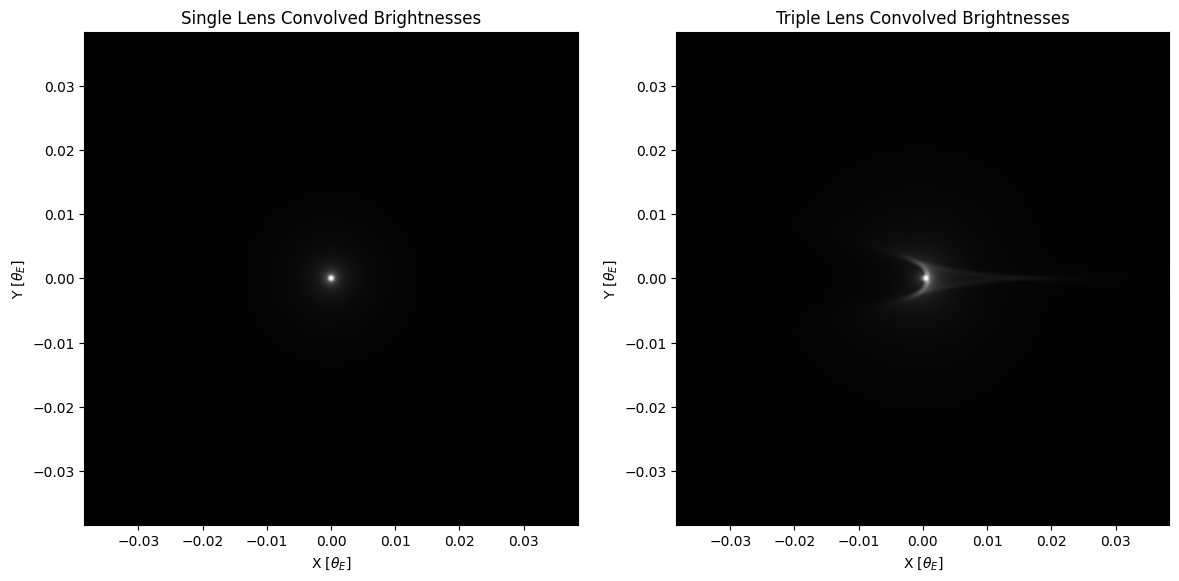

In [51]:
convolved_single_lens = single_lens.convolve(source_profile=source_profile)
convolved_triple_lens = triple_lens.convolve(source_profile=source_profile)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(convolved_single_lens, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])
ax2.imshow(convolved_triple_lens, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])

ax1.set_xlabel('X [$\\theta_E$]')
ax1.set_ylabel('Y [$\\theta_E$]')
ax1.set_title('Single Lens Convolved Brightnesses')
ax1.set_aspect('equal')

ax2.set_xlabel('X [$\\theta_E$]')
ax2.set_ylabel('Y [$\\theta_E$]')
ax2.set_title('Triple Lens Convolved Brightnesses')
ax2.set_aspect('equal')

plt.show()

#### Calculating VBMicrolensing caustics

In [52]:
parameters = [item for sublist in triple_lens.lens_att for idx, item in enumerate(sublist) if idx != 2]
VBM.SetLensGeometry(parameters)

caustic_points = VBM.Multicaustics()

#### Plotting deviation contours

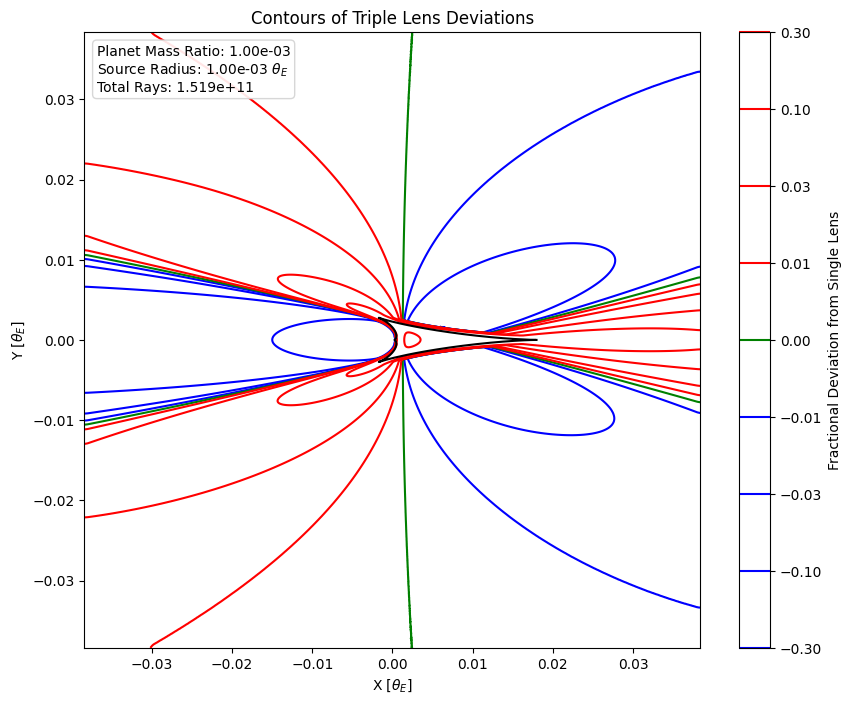

In [55]:
fractional_deviations = (convolved_triple_lens - convolved_single_lens) / convolved_single_lens

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

# img = ax.imshow(fractional_deviations, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2], cmap='grey')

img = plt.contour(single_lens.X_pix, single_lens.Y_pix, fractional_deviations,
                   levels=[-0.30, -0.10, -0.03, -0.01, 0, 0.01, 0.03, 0.10, 0.30],
                   colors=['blue', 'blue', 'blue', 'blue', 'green', 'red', 'red', 'red', 'red']
)

bar = plt.colorbar(img)
bar.set_label('Fractional Deviation from Single Lens')

for caustic_point in caustic_points:
    ax.plot(caustic_point[0], caustic_point[1], color='black')

ax.set_title(f'Contours of Triple Lens Deviations')
ax.set_aspect('equal')
ax.set_xlim(-ang_width/2, ang_width/2)
ax.set_ylim(-ang_width/2, ang_width/2)

props = dict(boxstyle='round', facecolor='white', edgecolor='lightgray', alpha=0.9)
ax.text(0.02, 0.98, f'Planet Mass Ratio: {(triple_lens.lens_att[2][3] / triple_lens.lens_att[1][3]):.2e}\nSource Radius: {radius:.2e} $\\theta_E$\nTotal Rays: {(single_lens.num_rays):.3e}', va='top', zorder=10, bbox=props, transform=ax.transAxes, color='black')

ax.set_xlabel('X [$\\theta_E$]')
ax.set_ylabel('Y [$\\theta_E$]')

fig.savefig('Contours.png', dpi=500)

plt.show()

(2000,)


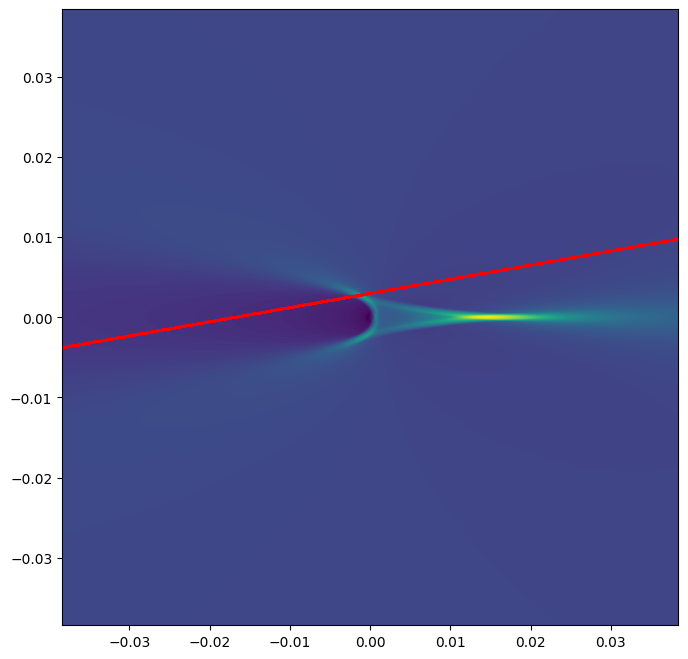

In [70]:
# Impact parameter
u = 0.003

# Angle from x axis
alpha = 10

intersections, (xs, ys), (tE_start, tE_end), brightnesses = IRSC.IRSCaustics.lightcurve_calculator(u, alpha, ang_width, fractional_deviations)

print(brightnesses.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.imshow(fractional_deviations, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2])
ax.scatter(xs, ys, s=1, color='red')

plt.show()

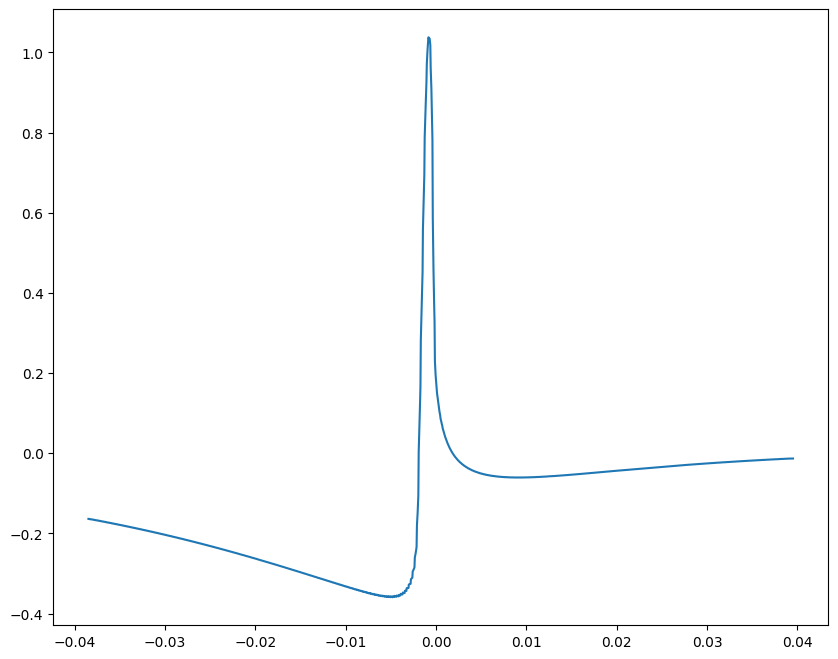

In [71]:
times = np.linspace(tE_start, tE_end, brightnesses.shape[0])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.plot(times, brightnesses)

plt.show()

-0.03723073514884746
0.040757274763016764


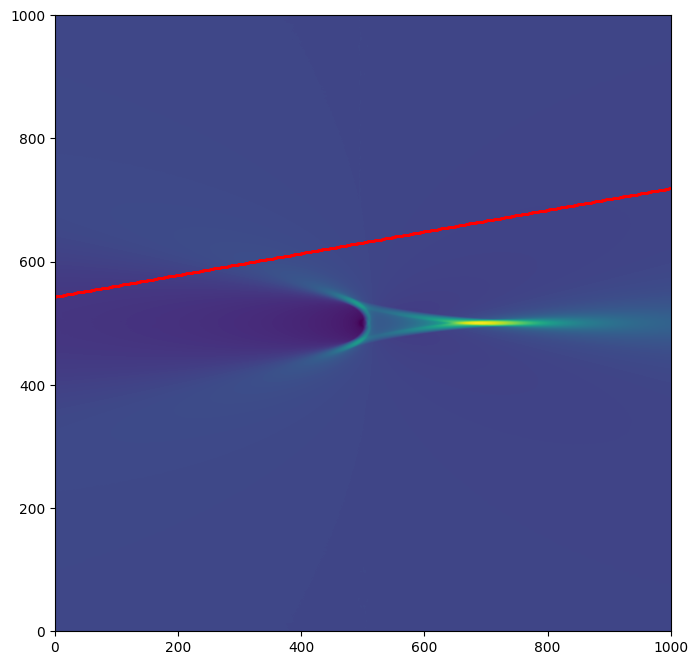

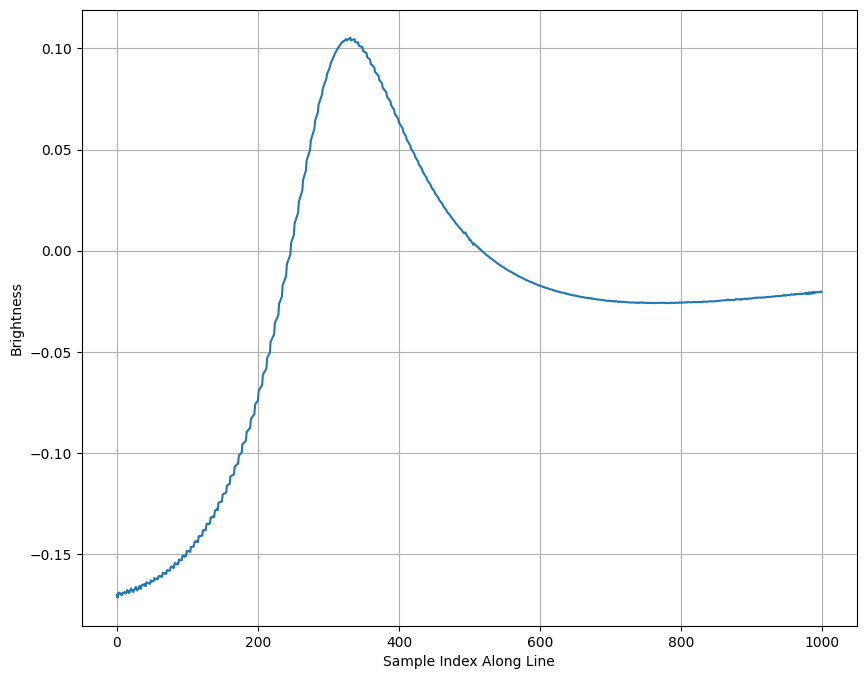

In [ ]:
# Impact parameter
u = 0.01

# Angle from x axis
alpha = 45

# Get the intersections of the line with the box edges
intersections = get_line_box_intersections(u, alpha, ang_width)

start = intersections[0]
end = intersections[1]

brightnesses = fractional_deviations

offset = (pixels - 1) / 2.0

start = np.floor(start/ang_res + offset)
end = np.floor(end/ang_res + offset)

# Get line pixel coordinates
rr, cc = line(int(start[1]), int(start[0]), int(end[1]), int(end[0]))

# Get brightness values along the line
line_values = brightnesses[rr[1:], cc[1:]]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.imshow(brightnesses, extent=[0, pixels, 0, pixels])
ax.scatter(cc[1:], rr[1:], s=1, color='red')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.plot(line_values)
ax.set_xlabel("Sample Index Along Line")
ax.set_ylabel("Brightness")
ax.grid(True)

plt.show()